<figure>
  <IMG SRC="https://raw.githubusercontent.com/fmeer/public-files/main/TUlogo.png" WIDTH=150 ALIGN="right">
</figure>

# **CEGM2003 project: Bayesian optimization for truss structures**
    
In this notebook, the finite element code `pyJive` is applied to frequency analysis of a truss structure. Specifically, the `ModeShapeModule` is used to compute the natural frequencies of a 37-bar truss bridge structure. The case has been investigated in literature with multiple optimization algorithms, see [Kanarachos et al., 2017](https://dx.doi.org/10.1016/j.compstruc.2016.11.005) for a description of the case and a comparison of the performance of diffferent optimization methods. 
    
Below, the truss is first analyzed with the default settings and then with the optimal parameters from Kanarachos. The notebook demonstrates how to run the finite element program and how to change those inputs that define the design space for the optimization problem. 

In [30]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm
from scipy.optimize import minimize
import sys
import pandas as pd
import contextlib
import io

sys.path.append(r'..\TRUSS1\pyJive')
sys.path.append(r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q2\CEGM2003 - Data Science and Artificial Inteligence for engineers\!Content\Unit 0 - Project\TRUSS1\pyJive')

from utils import proputils as pu
import main
from names import GlobNames as gn

%matplotlib widget

## Starting design

The analysis is based on two input files. The main input file, `bridge_frequency.pro` contains all input parameters and other settings of the analysis. It also refers to a second file `bridge.geom`, which defines the geometry and mesh. The initial input matches the starting point of the optimization procedure following Kanarachos. 

In [ ]:
# Read the input file and store in props object
props = pu.parse_file('bridge_frequency.pro')

# Call the program and store output in globdat
globdat = main.jive(props)

# Write additional output
print('Smallest three natural frequencies: ', globdat[gn.EIGENFREQS][0:3]/2/np.pi, ' Hz')

### Optimal design from Kanarachos

Now, two changes are made to the problem settings to make the analysis match the optimum solution of Kanarachos. The `props` object, which contains the information from `bridge.pro` in the form of a nested `dict` is overwritten at two of its entries.
- **Cross sectional areas:** these are defined in `props['model']['truss']['area']`
- **Truss geometry:** for this a separate `.geom` file has already been prepared and the program is told to use this one by overwriting the entry `props['init']['mesh']['file']`. Check the differences between the two `.geom`-files in this folder to see how the geometry is updated.

In [ ]:
# Overwrite relevant inputs
props['model']['truss']['area'] = [ 40e-4, 3.1997e-4, 1.0025e-4, 1.0000e-4, 2.5875e-4, 1.0895e-4, 1.1261e-4, 2.5624e-4, 1.4121e-4, 1.5758e-4, 2.2461e-4, 1.0694e-4, 1.3193e-4, 2.3846e-4, 1.0001e-4 ]
props['init']['mesh']['file'] = 'bridge_kanarachos.geom'

# Call program with updated inputs
globdat = main.jive(props)
print('Smallest three natural frequencies: ', globdat[gn.EIGENFREQS][0:3]/2/np.pi, ' Hz')

## Definitions

In [4]:
class BayesianOptimizer():
      
    def __init__(self, target_func, x_init, y_init, n_iter, scale, batch_size):
        self.x_init = x_init
        self.y_init = y_init
        self.target_func = target_func
        self.n_iter = n_iter
        self.scale = scale
        self.batch_size = batch_size
        self.gauss_pr = GaussianProcessRegressor()
        self.best_samples_ = pd.DataFrame(columns = ['x', 'y', 'ei'])
        self.distances_ = []

    def _get_expected_improvement(self, x_new):

        # Using estimate from Gaussian surrogate instead of actual function for 
        # a new trial data point to avoid cost 
 
        mean_y_new, sigma_y_new = self.gauss_pr.predict(np.array([x_new]), return_std=True)
        sigma_y_new = sigma_y_new.reshape(-1,1)
        if sigma_y_new == 0.0:
            return 0.0
        
        # Using estimates from Gaussian surrogate instead of actual function for 
        # entire prior distribution to avoid cost
        
        mean_y = self.gauss_pr.predict(self.x_init)
        max_mean_y = np.max(mean_y)
        z = (mean_y_new - max_mean_y) / sigma_y_new
        exp_imp = (mean_y_new - max_mean_y) * norm.cdf(z) + sigma_y_new * norm.pdf(z)
        
        return exp_imp
    
    def _acquisition_function(self, x):
        return -self._get_expected_improvement(x)
        
    def _get_next_probable_point(self):
            min_ei = float(sys.maxsize)
            x_optimal = None 
                
            # Trial with an array of random data points
                
            for x_start in (np.random.random((self.batch_size,self.x_init.shape[1])) * self.scale):
                response = minimize(fun=self._acquisition_function, x0=x_start, method='L-BFGS-B')
                # print(response.fun)
                # if response.fun[0] < min_ei:
                if response.fun < min_ei:
                    # min_ei = response.fun[0]
                    min_ei = response.fun
                    x_optimal = response.x
                
                return x_optimal, min_ei
    def _extend_prior_with_posterior_data(self, x,y):
        self.x_init = np.append(self.x_init, np.array([x]), axis = 0)
        self.y_init = np.append(self.y_init, np.array(y), axis = 0)
  
    def optimize(self):
        y_max_ind = np.argmax(self.y_init)
        y_max = self.y_init[y_max_ind]
        optimal_x = self.x_init[y_max_ind]
        optimal_ei = None
        for i in range(self.n_iter):
            self.gauss_pr.fit(self.x_init, self.y_init)
            x_next, ei = self._get_next_probable_point()
            y_next = self.target_func(np.array([x_next]))
            self._extend_prior_with_posterior_data(x_next,y_next)
                
            if y_next[0] > y_max:
                y_max = y_next[0]
                optimal_x = x_next
                # optimal_ei = ei[0]
                optimal_ei = ei

            if i == 0:
                prev_x = x_next
            else:
                self.distances_.append(np.linalg.norm(prev_x - x_next))
                prev_x = x_next
                
            self.best_samples_ = self.best_samples_.append({"y": y_max, "ei": optimal_ei},ignore_index=True)
            
        return optimal_x, y_max

In [5]:
class GeometryProcessor:
    def __init__(self, file_path, cross_sections):
        self.file_path = file_path
        self.nodes = {}
        self.cross_sections = cross_sections 
        self.member_df = None
        self.connectivity = None

    def read_geom_file(self):
        with open(self.file_path, 'r') as file:
            lines = file.readlines()

        nodes = {}
        members = []
        section = None

        for line in lines:
            line = line.strip()
            if line.startswith('node:'):
                section = 'node'
                continue
            elif line.startswith('member:'):
                section = 'member'
                continue

            if section == 'node' and line:
                parts = line.split()
                node_number = int(parts[0])
                node_data = tuple(map(float, parts[1:]))
                nodes[node_number] = node_data
            elif section == 'member' and line:
                member_data = tuple(map(int, line.split()))
                members.append(member_data)

        self.nodes = nodes
        self.member_df = pd.DataFrame(members, columns=['Node #1', 'Node #2', 'Number of Elements', 'Cross-section Type'])
        self.member_df = self.member_df.drop('Number of Elements', axis=1)
        self.connectivity = self.member_df.to_numpy()

    def write_geom_file(self, output_file_path):
        geom = 'node: node #, x-coordinate; y-coordinate\n'
        for node_num, coords in self.nodes.items():
            geom += f"{node_num} {' '.join(map(str, coords))}\n"
        
        geom += '\nmember: Node #1; Node #2; number of elements; cross-section type\n'
        for row in self.connectivity:
            geom += ' '.join(map(str, row)) + '\n'

        with open(output_file_path, 'w') as file:
            file.write(geom)

        return geom

In [28]:
def FEMsolver(object,output_path):
    
    geometry = object.nodes
    CrossSection = object.cross_sections

    props['model']['truss']['area'] = CrossSection
    geom = object.write_geom_file(output_path)
    props['init']['mesh']['file'] = output_path
    
    f = io.StringIO()
    with contextlib.redirect_stdout(f):
        globdat = main.jive(props)

    #globdat = main.jive(props)
    
    NFreq = globdat[gn.EIGENFREQS][0:3]/2/np.pi 
    if any(frequency < 20 for frequency in NFreq):
        return float('inf')  # Representing an infeasible solution with an infinite penalty
    
    return NFreq

## Optimisation 

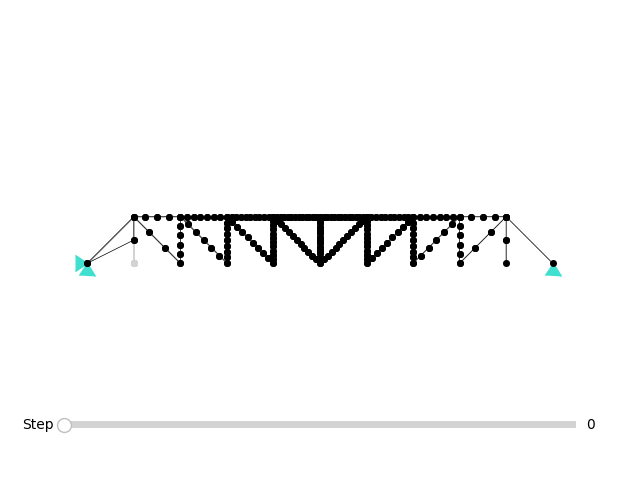

In [29]:
# -------------------------------- DEFINITIONS ------------------------------- #
file_path = r'bridge.geom'
output_path = 'TRUSS1.geom'
cross_sections = [40e-4, 3.1997e-4, 1.0025e-4, 1.0000e-4, 2.5875e-4, 1.0895e-4, 1.1261e-4, 2.5624e-4, 1.4121e-4, 1.5758e-4, 2.2461e-4, 1.0694e-4, 1.3193e-4, 2.3846e-4, 1.0001e-4 ]

# -------------------------------- PROCESSING -------------------------------- #
geom_processor = GeometryProcessor(file_path,cross_sections)
geom_processor.read_geom_file()
node_locations = list(geom_processor.nodes.values())

# print("Nodes locations:", geom_processor.nodes)
# print("Connectivity Matrix [Node i, Node j, Cross Section z]:", geom_processor.connectivity)
# print("Cross Sections z0 to zN", cross_sections)

x_input = geom_processor.connectivity
x_input = x_input.astype(float)
x_input[:, 2] = np.array([cross_sections[item] for item in geom_processor.connectivity[:,2]])

x_init = np.array(x_input)  # Initial design variables (areas and joint locations)
y_init = FEMsolver(geom_processor,output_path)  # Initial natural frequencies obtained from simulations

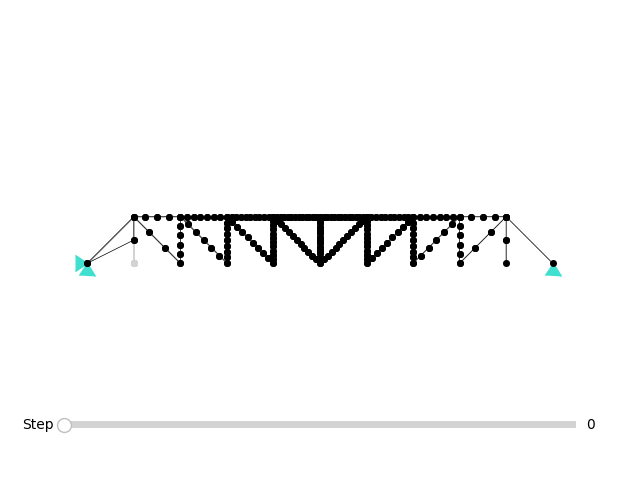

TypeError: 'float' object is not subscriptable

In [31]:
optimizer = BayesianOptimizer(
    target_func= FEMsolver(object,output_path),
    x_init=x_init,
    y_init=y_init,
    n_iter=100,
    scale=1.0,  # Adjust based on expected variation in your design variables
    batch_size=10
)

optimal_design, max_frequency = optimizer.optimize()